# Altitude + Eccentricity Station-keeping Sequence

In this notebook we will demonstrate how to raise the altitude of a satellite while maintaining eccentricity, and adhering to constraints:
- 20 minute gap between sequential burns
- Maximum burn time of half an orbit

Additionally, we will propagate with an EGM96 gravity model and atmospheric drag, and third body perturbations. The Sequence is said to be complete when we are at our target altitude.

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

from ostk.core.filesystem import Directory

from ostk.mathematics.geometry.d3.object import Cuboid
from ostk.mathematics.geometry.d3.object import Composite
from ostk.mathematics.geometry.d3.object import Point

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.environment.object.celestial import Earth
from ostk.physics.environment.object.celestial import Moon
from ostk.physics.environment.object.celestial import Sun
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.time import Instant
from ostk.physics.time import Scale
from ostk.physics.time import Time
from ostk.physics.unit import Length
from ostk.physics.unit import Mass

from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.dynamics import Thruster
from ostk.astrodynamics.event_condition import RealCondition
from ostk.astrodynamics.event_condition import LogicalCondition
from ostk.astrodynamics.event_condition import BooleanCondition
from ostk.astrodynamics.trajectory.orbit.model.brouwerLyddaneMean import (
    BrouwerLyddaneMeanShort,
)
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory import Sequence
from ostk.astrodynamics.trajectory import StateBuilder
from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory.state import CoordinateBroker, CoordinateSubset
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianPosition
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianVelocity
from ostk.astrodynamics.trajectory.orbit.model.kepler import COE
from ostk.astrodynamics.flight.system import SatelliteSystem
from ostk.astrodynamics.flight.system import PropulsionSystem
from ostk.astrodynamics.guidance_law import QLaw

## User inputs

In [2]:
earth = Earth.from_models(
    EarthGravitationalModel(
        EarthGravitationalModel.Type.EGM96, Directory.undefined(), 20, 20
    ),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(EarthAtmosphericModel.Type.NRLMSISE00),
)

environment = Environment(Instant.J2000(), [earth, Sun.default(), Moon.default()])

In [3]:
instant = Instant.date_time(DateTime(2023, 1, 1), Scale.UTC)
orbit = Orbit.sun_synchronous(
    instant, Length.kilometers(580.0), Time.midnight(), Earth.default()
)
initial_state = orbit.get_state_at(instant)

In [4]:
mass = Mass.kilograms(200.0)
wet_mass = Mass.kilograms(215.0)
propulsion_system = PropulsionSystem(thrust_si_unit=0.1, specific_impulse_si_unit=100.0)

## Setup environment, initial state and Satellite System

In [5]:
satellite_geometry = Composite(
    Cuboid(Point(0.0, 0.0, 0.0), np.eye(3).tolist(), [1.0, 0.0, 0.0])
)
satellite_system = SatelliteSystem(
    mass, satellite_geometry, np.eye(3), 2.0, 2.2, propulsion_system
)

In [6]:
coordinates_broker = CoordinateBroker(
    [
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinateSubset.mass(),
        CoordinateSubset.surface_area(),
        CoordinateSubset.drag_coefficient(),
    ]
)

state_builder = StateBuilder(
    frame=Frame.GCRF(),
    coordinate_subsets=[
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinateSubset.mass(),
        CoordinateSubset.surface_area(),
        CoordinateSubset.drag_coefficient(),
    ],
)

coordinates = [
    *initial_state.get_coordinates().tolist(),
    wet_mass.in_kilograms(),
    satellite_system.get_cross_sectional_surface_area(),
    satellite_system.get_drag_coefficient(),
]

initial_state = state_builder.build(initial_state.get_instant(), coordinates)

In [7]:
dynamics = Dynamics.from_environment(environment)
numerical_solver = NumericalSolver.default_conditional()

### Sequence

In [8]:
sequence = Sequence(
    numerical_solver=numerical_solver,
    dynamics=dynamics,
    maximum_propagation_duration=Duration.days(30.0),
    verbosity=0,
)

### Maneuver segment

In [9]:
initial_coe = orbit.access_kepler_model().get_classical_orbital_elements()
target_coe = COE(
    initial_coe.get_semi_major_axis() + Length.kilometers(3.0),
    initial_coe.get_eccentricity(),
    initial_coe.get_inclination(),
    initial_coe.get_raan(),
    initial_coe.get_aop(),
    initial_coe.get_true_anomaly(),
)
q_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-4),
        }
    ),
)
thruster_dynamics = Thruster(satellite_system, q_law)

In [10]:
evaluator = (
    lambda state: BrouwerLyddaneMeanShort.cartesian(
        (state.get_position(), state.get_velocity()),
        EarthGravitationalModel.EGM2008.gravitational_parameter,
    )
    .get_semi_major_axis()
    .in_meters()
)

# Burn till +km from current SMA
sma_condition = RealCondition(
    name="Mean SMA crossing - thrust",
    criterion=RealCondition.Criterion.StrictlyPositive,
    evaluator=evaluator,
    target_value=evaluator(initial_state) + 5000.0,
)

# Don't burn more than half an orbit
duration_condition = RealCondition.duration_condition(
    criterion=RealCondition.Criterion.StrictlyPositive,
    duration=initial_coe.get_orbital_period(
        EarthGravitationalModel.EGM2008.gravitational_parameter
    )
    / 2.0,
)

# Don't burn if we are in eclipse
eclipse_condition = BooleanCondition(
    "Not in eclipse",
    BooleanCondition.Criterion.AnyCrossing,
    lambda state: environment.is_position_in_eclipse(state.get_position()),
    False,
)


# Stop if either condition is met
maneuver_condition = LogicalCondition(
    "maneuver condition",
    LogicalCondition.Type.Or,
    [sma_condition, duration_condition, eclipse_condition],
)

sequence.add_maneuver_segment(
    maneuver_condition,
    thruster_dynamics,
)

### Coast segment

In [11]:
# coast for atleast 20.0 minutes
duration_condition = RealCondition.duration_condition(
    criterion=RealCondition.Criterion.StrictlyPositive,
    duration=Duration.minutes(20.0),
)

# coast while in eclipse
eclipse_condition = BooleanCondition(
    "Eclipse",
    BooleanCondition.Criterion.AnyCrossing,
    lambda state: not environment.is_position_in_eclipse(state.get_position()),
    False,
)

# Stop when we are out of eclipse AND atleast 20 minutes has passed
coast_condition = LogicalCondition(
    "Coast condition",
    LogicalCondition.Type.And,
    [eclipse_condition, duration_condition],
)

sequence.add_coast_segment(coast_condition)

In [12]:
sol = sequence.solve_to_condition(initial_state, sma_condition)
states = sol.get_states()

In [13]:
data = []
for state in states:
    blmshort = BrouwerLyddaneMeanShort.cartesian(
        (state.get_position(), state.get_velocity()),
        earth.get_gravitational_parameter(),
    )
    data.append(
        {
            "altitude": float(
                blmshort.get_semi_major_axis().in_kilometers()
                - earth.get_equatorial_radius().in_kilometers()
            ),
            "mass": float(state.get_coordinates()[6]),
            "eccentricity": float(blmshort.get_eccentricity()),
            "periapsis": float(blmshort.get_periapsis_radius().in_kilometers()),
            "apoapsis": float(blmshort.get_apoapsis_radius().in_kilometers()),
            "time": state.get_instant().get_date_time(Scale.UTC),
            "x": state.get_coordinates()[0],
            "y": state.get_coordinates()[1],
            "z": state.get_coordinates()[2],
        }
    )
df = pd.DataFrame(data)

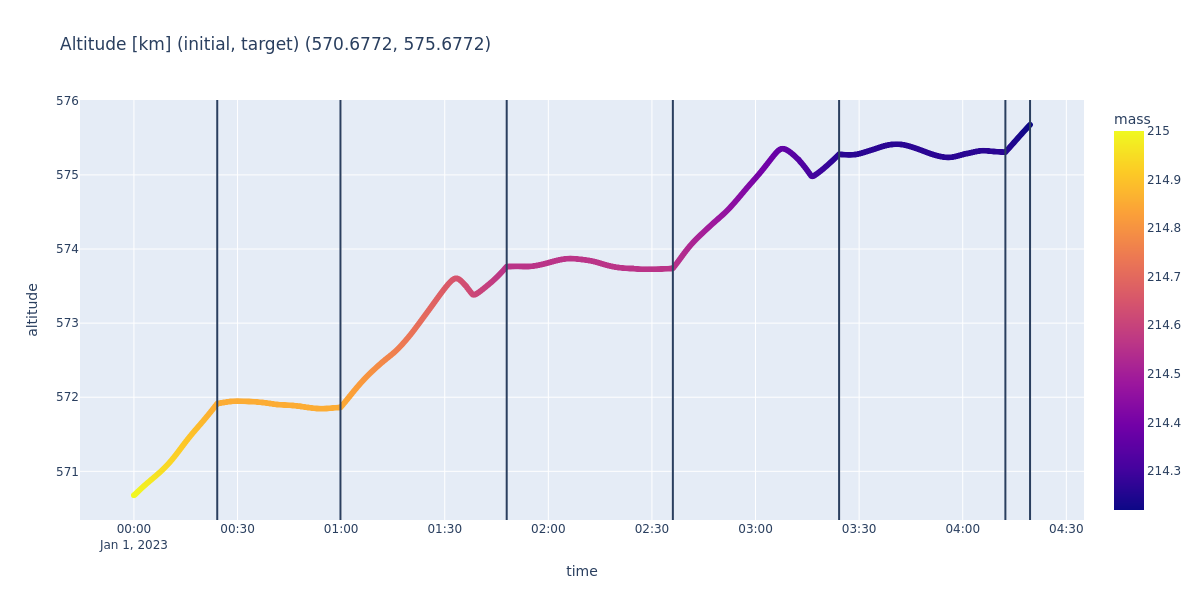

In [14]:
figure = px.scatter(
    df,
    x="time",
    y="altitude",
    color="mass",
    title=f"Altitude [km] (initial, target) ({float(evaluator(initial_state) - earth.get_equatorial_radius().in_meters()) / 1000.0:.4f}, {float(sma_condition.get_target().value - earth.get_equatorial_radius().in_meters()) / 1000.0:.4f})",
    height=600,
    width=1200,
)
for segment_solution in sol.segment_solutions:
    time = segment_solution.states[-1].get_instant().get_date_time(Scale.UTC)
    figure.add_vline(x=time.isoformat())
figure.show("png")

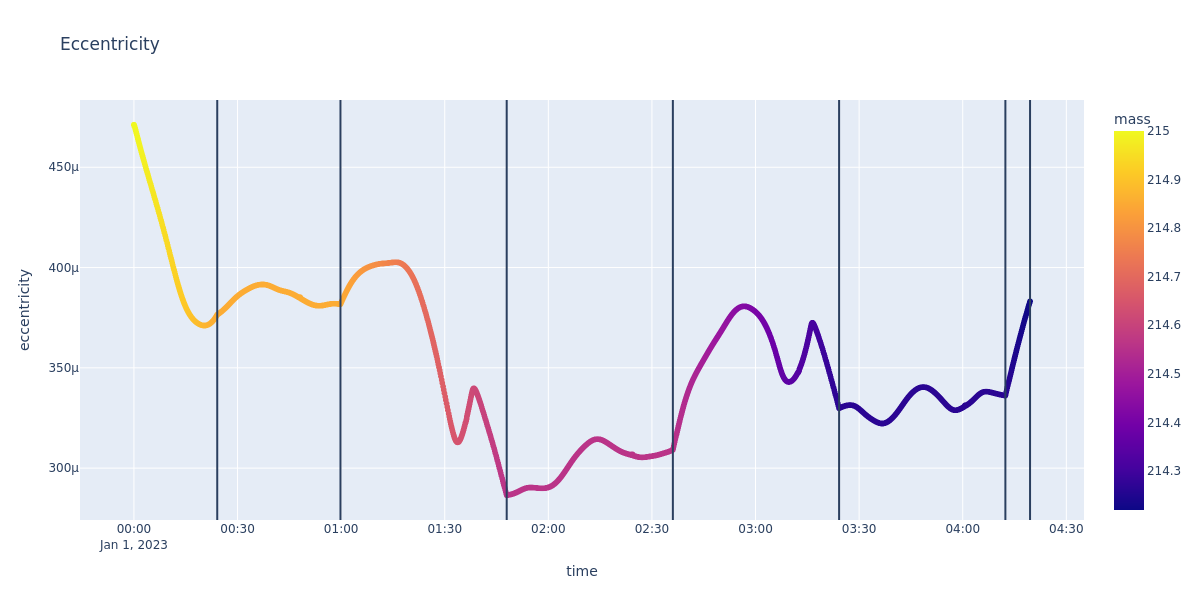

In [15]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="mass",
    title=f"Eccentricity",
    height=600,
    width=1200,
)
for segment_solution in sol.segment_solutions:
    time = segment_solution.states[-1].get_instant().get_date_time(Scale.UTC)
    figure.add_vline(x=time.isoformat())
figure.show("png")

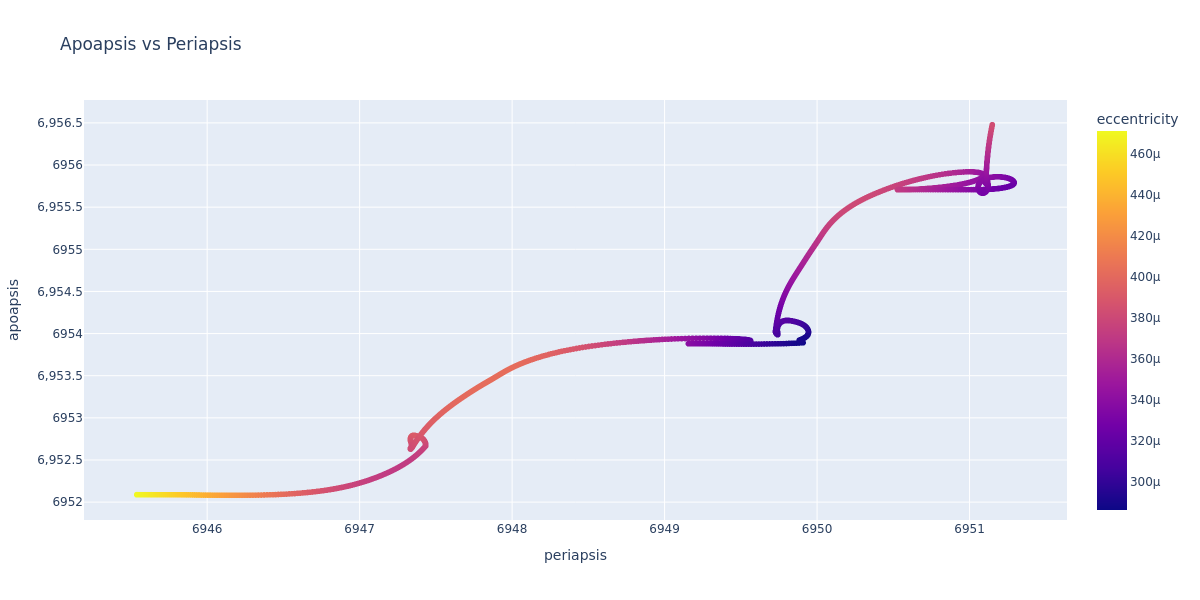

In [16]:
figure = px.scatter(
    df,
    x="periapsis",
    y="apoapsis",
    color="eccentricity",
    title="Apoapsis vs Periapsis",
    height=600,
    width=1200,
)
figure.show("png")